# Step 1: Import Libraries and Set Up Modules


This step installs necessary packages, imports required libraries, and sets up custom modules. We clone the GitHub repository containing our custom modules, move them to the current directory, and then import them. This ensures we have all the necessary tools and functions for our melanoma detection project

In [1]:
# Install necessary packages
!pip install torch torchvision torchinfo opendatasets

# Import required libraries
import torch
import torchvision
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from torch.utils.tensorboard import SummaryWriter

# Print PyTorch and torchvision versions
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

# Clone the GitHub repository with custom modules
!git clone https://github.com/mlgomez0/melanoma-detection-model
!mv melanoma-detection-model/modules .
!mv melanoma-detection-model/models .
!rm -rf melanoma-detection-model


# Import custom modules
from modules import data_setup, engine, metrics

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

print("All modules imported successfully.")

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

# Step 2: Download and Prepare the Dataset



This step downloads the dataset from Kaggle, organizes it into train and test folders, and then creates DataLoaders. It ensures that the necessary directory structure is in place before attempting to create the DataLoaders. This approach should work in a new Colab session where the data hasn't been previously downloaded or organized.

In [2]:
# Install necessary packages
!pip install opendatasets --upgrade --quiet

# Import required libraries
import opendatasets as od
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil

# Download the dataset
dataset_url = 'https://www.kaggle.com/datasets/nischaydnk/isic-2019-jpg-224x224-resized'
od.download(dataset_url)

# Define paths
dataset_path = 'isic-2019-jpg-224x224-resized/train-image/image'
metadata_path = 'isic-2019-jpg-224x224-resized/train-metadata.csv'
output_path = 'data'

# Function to create train and test folders
def create_train_test_folders(dataset_path, metadata_path, output_path):
    # Load metadata CSV
    df = pd.read_csv(metadata_path)

    # Split data into train and test
    train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['target'])

    # Create train and test directories
    train_dir = os.path.join(output_path, 'train')
    test_dir = os.path.join(output_path, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Copy images to train and test directories
    for index, row in train_df.iterrows():
        image_name = row['isic_id'] + '.jpg'
        image_path = os.path.join(dataset_path, image_name)
        target_folder = os.path.join(train_dir, str(row['target']))
        os.makedirs(target_folder, exist_ok=True)
        shutil.copy(image_path, target_folder)

    for index, row in test_df.iterrows():
        image_name = row['isic_id'] + '.jpg'
        image_path = os.path.join(dataset_path, image_name)
        target_folder = os.path.join(test_dir, str(row['target']))
        os.makedirs(target_folder, exist_ok=True)
        shutil.copy(image_path, target_folder)

# Create train and test folders
create_train_test_folders(dataset_path, metadata_path, output_path)

# Set up data directories
train_dir = 'data/train'
test_dir = 'data/test'

print("Dataset downloaded and organized into train and test folders.")

# Now create DataLoaders
from torchvision import transforms
from modules import data_setup

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=transform,
    batch_size=32
)

print(f"Classes: {class_names}")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: darlingoscanoa
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/nischaydnk/isic-2019-jpg-224x224-resized


100%|██████████| 355M/355M [00:07<00:00, 50.4MB/s]



Dataset downloaded and organized into train and test folders.
Classes: ['0', '1']


# Step 3: Set Up Device and Create DataLoaders


This step sets up the device (GPU if available, otherwise CPU) for training and loads the data. We use the same data setup as in the previous notebook, ensuring consistency in our dataset. The DataLoaders are created to efficiently load and preprocess the images during training

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=transform,
    batch_size=32
)

print(f"Classes: {class_names}")

Using device: cuda
Classes: ['0', '1']


# Step 4: Load the Saved MLP Model

In this step, we define the MLP class to match the architecture of our saved model. We then load the saved model weights and set it to evaluation mode. The model summary is printed to confirm the loaded architecture

In [4]:
# Define the MLP model structure
class MLP(nn.Module):
    def __init__(self, input_features, hidden_units, output_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_features)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.layer_stack(x)

# Load the saved MLP model
model = MLP(224*224*3, 64, len(class_names)).to(device)
model.load_state_dict(torch.load("models/mlp_model.pth"))
model.eval()

print("Loaded MLP model:")
summary(model, input_size=(1, 3, 224, 224))

Loaded MLP model:


Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 2]                    --
├─Flatten: 1-1                           [1, 150528]               --
├─Sequential: 1-2                        [1, 2]                    --
│    └─Linear: 2-1                       [1, 64]                   9,633,856
│    └─BatchNorm1d: 2-2                  [1, 64]                   128
│    └─ReLU: 2-3                         [1, 64]                   --
│    └─Linear: 2-4                       [1, 64]                   4,160
│    └─BatchNorm1d: 2-5                  [1, 64]                   128
│    └─ReLU: 2-6                         [1, 64]                   --
│    └─Linear: 2-7                       [1, 2]                    130
Total params: 9,638,402
Trainable params: 9,638,402
Non-trainable params: 0
Total mult-adds (M): 9.64
Input size (MB): 0.60
Forward/backward pass size (MB): 0.00
Params size (MB): 38.55
Estimated Total Size (MB):

# Step 5: Freeze Base Layers and Add New Layers

This step demonstrates transfer learning by freezing the base layers of our pre-trained model. We then add new layers on top of the frozen base to allow the model to learn new features specific to our task. This approach leverages the knowledge from the pre-trained model while adapting to our specific dataset

-It prints the original model structure for reference.

-It recreates the base model structure to ensure consistency and correct dimensions.

-It freezes all layers except the last one in the original layer_stack.

-It adds new layers for transfer learning, ensuring proper connections between layers.

-It prints the modified model structure.

-Finally, it uses torchinfo.summary() to display a summary of the modified model.



In [5]:
# Print original model structure
print("Original model structure:")
print(model)

# Recreate the base model structure
model.layer_stack = nn.Sequential(
    nn.Linear(150528, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, len(class_names))
)

# Freeze all layers except the last one
for param in list(model.layer_stack.children())[:-1]:
    for p in param.parameters():
        p.requires_grad = False

# Add new layers for transfer learning
model.layer_stack = nn.Sequential(
    model.layer_stack,
    nn.Linear(len(class_names), 32),
    nn.ReLU(),
    nn.Linear(32, len(class_names))
)

# Print modified model structure
print("\nModified model structure:")
print(model)

print("\nModified model for transfer learning:")
summary(model, input_size=(1, 3, 224, 224))

Original model structure:
MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_stack): Sequential(
    (0): Linear(in_features=150528, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)

Modified model structure:
MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_stack): Sequential(
    (0): Sequential(
      (0): Linear(in_features=150528, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 2]                    --
├─Flatten: 1-1                           [1, 150528]               --
├─Sequential: 1-2                        [1, 2]                    --
│    └─Sequential: 2-1                   [1, 2]                    --
│    │    └─Linear: 3-1                  [1, 64]                   (9,633,856)
│    │    └─BatchNorm1d: 3-2             [1, 64]                   (128)
│    │    └─ReLU: 3-3                    [1, 64]                   --
│    │    └─Linear: 3-4                  [1, 64]                   (4,160)
│    │    └─BatchNorm1d: 3-5             [1, 64]                   (128)
│    │    └─ReLU: 3-6                    [1, 64]                   --
│    │    └─Linear: 3-7                  [1, 2]                    130
│    └─Linear: 2-2                       [1, 32]                   96
│    └─ReLU: 2-3                         [1, 32]                

# Step 6: Set Up Training Parameters


Here we set up the training parameters for our transfer learning process. We use the same loss function as before but only optimize the parameters of the new layers we added. The learning rate scheduler helps in adjusting the learning rate during training.

In [6]:
# Set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Step 7: Train the Modified Model

This step trains the modified model using transfer learning. We use the same training loop as before, but now we're only updating the weights of the new layers we added. The training progress is tracked and printed for each epoch

In [7]:
# Custom training loop
results = {"train_loss": [], "train_acc": [], "train_recall": [], "test_loss": [], "test_acc": [], "test_recall": []}

num_epochs = 40
for epoch in range(num_epochs):
    train_loss, train_acc = engine.train_step(model, train_dataloader, loss_fn, optimizer, device)
    test_loss, test_acc = engine.test_step(model, test_dataloader, loss_fn, device)

    # Calculate recall for both train and test sets
    train_recall = metrics.calculate_recall(model, train_dataloader, device)
    test_recall = metrics.calculate_recall(model, test_dataloader, device)

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["train_recall"].append(train_recall)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    results["test_recall"].append(test_recall)

    print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | train_recall: {train_recall:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f} | test_recall: {test_recall:.4f}")

    # Step the scheduler
    scheduler.step(test_loss)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.4558 | train_acc: 0.8221 | train_recall: 0.8250 | test_loss: 0.4371 | test_acc: 0.8194 | test_recall: 0.8224


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 2 | train_loss: 0.4279 | train_acc: 0.8264 | train_recall: 0.8318 | test_loss: 0.4278 | test_acc: 0.8225 | test_recall: 0.8255


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 3 | train_loss: 0.4233 | train_acc: 0.8278 | train_recall: 0.8311 | test_loss: 0.4228 | test_acc: 0.8215 | test_recall: 0.8246


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 4 | train_loss: 0.4219 | train_acc: 0.8271 | train_recall: 0.8319 | test_loss: 0.4216 | test_acc: 0.8249 | test_recall: 0.8279


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 5 | train_loss: 0.4204 | train_acc: 0.8282 | train_recall: 0.8329 | test_loss: 0.4190 | test_acc: 0.8264 | test_recall: 0.8287


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 6 | train_loss: 0.4179 | train_acc: 0.8299 | train_recall: 0.8326 | test_loss: 0.4239 | test_acc: 0.8262 | test_recall: 0.8293


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 7 | train_loss: 0.4190 | train_acc: 0.8285 | train_recall: 0.8333 | test_loss: 0.4156 | test_acc: 0.8260 | test_recall: 0.8283


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 8 | train_loss: 0.4167 | train_acc: 0.8295 | train_recall: 0.8341 | test_loss: 0.4144 | test_acc: 0.8264 | test_recall: 0.8287


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 9 | train_loss: 0.4166 | train_acc: 0.8276 | train_recall: 0.8348 | test_loss: 0.4139 | test_acc: 0.8278 | test_recall: 0.8297


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 10 | train_loss: 0.4163 | train_acc: 0.8299 | train_recall: 0.8342 | test_loss: 0.4128 | test_acc: 0.8274 | test_recall: 0.8301


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 11 | train_loss: 0.4160 | train_acc: 0.8300 | train_recall: 0.8354 | test_loss: 0.4148 | test_acc: 0.8280 | test_recall: 0.8311


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 12 | train_loss: 0.4135 | train_acc: 0.8306 | train_recall: 0.8350 | test_loss: 0.4129 | test_acc: 0.8299 | test_recall: 0.8322


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 13 | train_loss: 0.4128 | train_acc: 0.8315 | train_recall: 0.8351 | test_loss: 0.4130 | test_acc: 0.8262 | test_recall: 0.8289


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 14 | train_loss: 0.4114 | train_acc: 0.8316 | train_recall: 0.8348 | test_loss: 0.4129 | test_acc: 0.8284 | test_recall: 0.8311


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 15 | train_loss: 0.4118 | train_acc: 0.8311 | train_recall: 0.8357 | test_loss: 0.4123 | test_acc: 0.8300 | test_recall: 0.8326


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 16 | train_loss: 0.4100 | train_acc: 0.8333 | train_recall: 0.8352 | test_loss: 0.4124 | test_acc: 0.8290 | test_recall: 0.8317


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 17 | train_loss: 0.4108 | train_acc: 0.8319 | train_recall: 0.8355 | test_loss: 0.4120 | test_acc: 0.8276 | test_recall: 0.8303


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 18 | train_loss: 0.4097 | train_acc: 0.8311 | train_recall: 0.8352 | test_loss: 0.4123 | test_acc: 0.8293 | test_recall: 0.8317


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 19 | train_loss: 0.4120 | train_acc: 0.8321 | train_recall: 0.8360 | test_loss: 0.4120 | test_acc: 0.8298 | test_recall: 0.8324


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 20 | train_loss: 0.4103 | train_acc: 0.8328 | train_recall: 0.8349 | test_loss: 0.4109 | test_acc: 0.8290 | test_recall: 0.8313


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 21 | train_loss: 0.4113 | train_acc: 0.8316 | train_recall: 0.8344 | test_loss: 0.4130 | test_acc: 0.8294 | test_recall: 0.8321


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 22 | train_loss: 0.4106 | train_acc: 0.8329 | train_recall: 0.8355 | test_loss: 0.4108 | test_acc: 0.8295 | test_recall: 0.8315


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 23 | train_loss: 0.4105 | train_acc: 0.8313 | train_recall: 0.8361 | test_loss: 0.4112 | test_acc: 0.8303 | test_recall: 0.8330


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 24 | train_loss: 0.4112 | train_acc: 0.8323 | train_recall: 0.8348 | test_loss: 0.4114 | test_acc: 0.8292 | test_recall: 0.8319


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 25 | train_loss: 0.4113 | train_acc: 0.8310 | train_recall: 0.8351 | test_loss: 0.4111 | test_acc: 0.8295 | test_recall: 0.8315


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 26 | train_loss: 0.4109 | train_acc: 0.8306 | train_recall: 0.8347 | test_loss: 0.4123 | test_acc: 0.8300 | test_recall: 0.8326


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 27 | train_loss: 0.4098 | train_acc: 0.8312 | train_recall: 0.8345 | test_loss: 0.4107 | test_acc: 0.8287 | test_recall: 0.8307


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 28 | train_loss: 0.4107 | train_acc: 0.8313 | train_recall: 0.8355 | test_loss: 0.4115 | test_acc: 0.8294 | test_recall: 0.8321


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 29 | train_loss: 0.4110 | train_acc: 0.8298 | train_recall: 0.8352 | test_loss: 0.4114 | test_acc: 0.8274 | test_recall: 0.8301


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 30 | train_loss: 0.4090 | train_acc: 0.8324 | train_recall: 0.8353 | test_loss: 0.4117 | test_acc: 0.8293 | test_recall: 0.8313


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 31 | train_loss: 0.4105 | train_acc: 0.8321 | train_recall: 0.8351 | test_loss: 0.4115 | test_acc: 0.8299 | test_recall: 0.8319


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 32 | train_loss: 0.4103 | train_acc: 0.8325 | train_recall: 0.8351 | test_loss: 0.4117 | test_acc: 0.8286 | test_recall: 0.8309


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 33 | train_loss: 0.4109 | train_acc: 0.8311 | train_recall: 0.8352 | test_loss: 0.4118 | test_acc: 0.8276 | test_recall: 0.8303


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 34 | train_loss: 0.4091 | train_acc: 0.8321 | train_recall: 0.8354 | test_loss: 0.4110 | test_acc: 0.8288 | test_recall: 0.8311


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 35 | train_loss: 0.4098 | train_acc: 0.8322 | train_recall: 0.8355 | test_loss: 0.4120 | test_acc: 0.8305 | test_recall: 0.8332


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 36 | train_loss: 0.4108 | train_acc: 0.8328 | train_recall: 0.8360 | test_loss: 0.4117 | test_acc: 0.8294 | test_recall: 0.8321


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 37 | train_loss: 0.4085 | train_acc: 0.8333 | train_recall: 0.8360 | test_loss: 0.4112 | test_acc: 0.8280 | test_recall: 0.8307


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 38 | train_loss: 0.4095 | train_acc: 0.8316 | train_recall: 0.8354 | test_loss: 0.4113 | test_acc: 0.8303 | test_recall: 0.8330


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 39 | train_loss: 0.4109 | train_acc: 0.8325 | train_recall: 0.8353 | test_loss: 0.4119 | test_acc: 0.8293 | test_recall: 0.8317


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 40 | train_loss: 0.4120 | train_acc: 0.8319 | train_recall: 0.8354 | test_loss: 0.4123 | test_acc: 0.8280 | test_recall: 0.8307


# Step 8: Visualize Results

This step visualizes the training and testing metrics (loss, accuracy, and recall) for our transfer learning model. The plots help us understand how the model's performance evolves over the training epochs and how it compares to the original model.

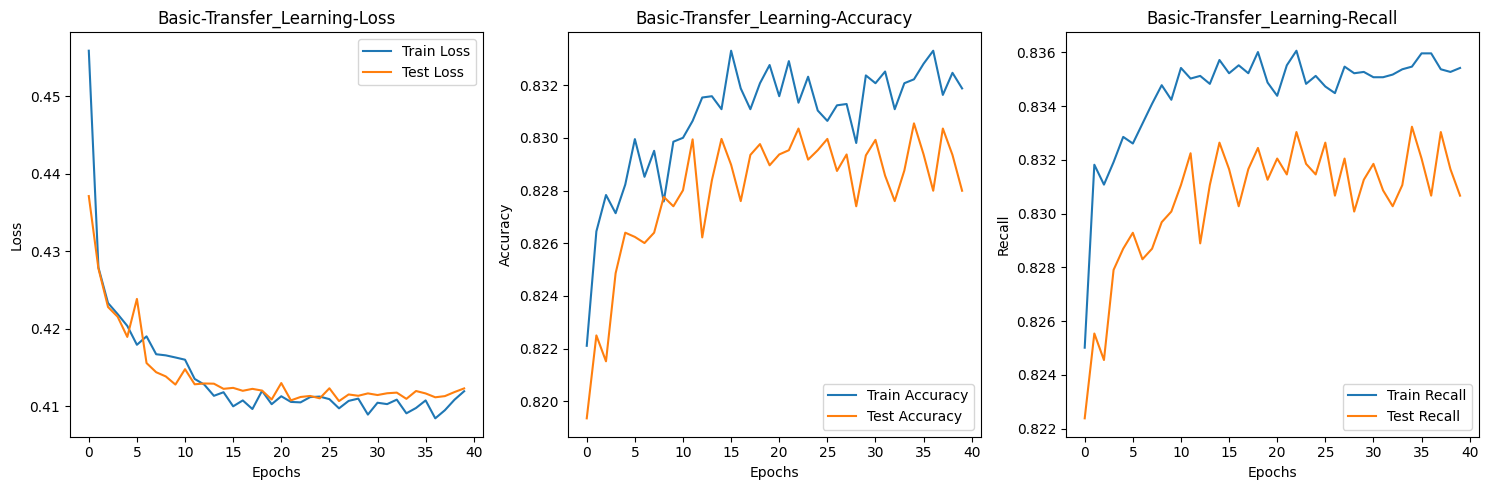

In [8]:
def plot_results(results):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(results['train_loss'], label='Train Loss')
    plt.plot(results['test_loss'], label='Test Loss')
    plt.title('Basic-Transfer_Learning-Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(results['train_acc'], label='Train Accuracy')
    plt.plot(results['test_acc'], label='Test Accuracy')
    plt.title('Basic-Transfer_Learning-Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(results['train_recall'], label='Train Recall')
    plt.plot(results['test_recall'], label='Test Recall')
    plt.title('Basic-Transfer_Learning-Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_results(results)

In our transfer learning experiment, we focused on modifying only the last layer of our pre-trained MLP model. Despite extending the training to 40 epochs, we did not observe significant improvement compared to our original MLP model. This result, while not showing the improvement we initially hoped for, provides valuable insights into the transfer learning process.

It highlights the critical importance of carefully selecting which layers to fine-tune and suggests that modifying only the last layer may not be the most effective approach for this particular task.

This experiment serves as a stepping stone for future research, indicating the need for a more comprehensive approach to layer selection in transfer learning.

Future experiments could explore fine-tuning multiple layers, gradually unfreezing layers during training, or investigating alternative architectures more suitable for transfer learning in melanoma detection.

These findings, although not showing improvement, are crucial in the scientific process, guiding our understanding of the limitations of certain approaches and informing future research directions.

# Step 9: Save the Transfer Learning Model

Here we save the weights of our transfer learning model. This allows us to use this improved model in future applications or for further fine-tuning without having to retrain from scratch

In [9]:
# Save the transfer learning model
torch.save(model.state_dict(), "models/transfer_learning_mlp.pth")
print("Transfer learning model saved.")

Transfer learning model saved.


# Step 10: Load and Test Saved Models

This step demonstrates how to load the saved models and test them to ensure they were saved correctly and still perform as expected. The models are loaded from disk, set to evaluation mode, and tested on the test dataset to check their accuracy.

In [10]:
def load_model(model_class, model_path, input_features, hidden_units, output_features):
    model = model_class(input_features, hidden_units, output_features).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Load the MLP model
loaded_model_1 = load_model(MLP, "models/mlp_model.pth", 224*224*3, 64, len(class_names))

# Test the loaded model
def test_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

print(f"Loaded MLP Accuracy: {test_model(loaded_model_1, test_dataloader):.2f}%")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loaded MLP Accuracy: 82.91%


# Step 11: Visualize the Model Architecture

This step visualizes the architecture of the MLP model using the torchviz library. It creates a graphical representation of the model's structure, showing the layers and connections. The visualization is saved as a PNG file

In [12]:
# Install torchviz
!pip install torchviz

from torchviz import make_dot

# Visualize MLP Model
x = torch.randn(1, 3, 224, 224).to(device)  # Example input
y = loaded_model_1(x)
dot = make_dot(y, params=dict(loaded_model_1.named_parameters()))
dot.render("mlp_architecture", format="png")

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=bf76df72eb9c2b03ac5b19c400aaeaf70e8e4c26125727212ec713d8d275004c
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


'mlp_architecture.png'

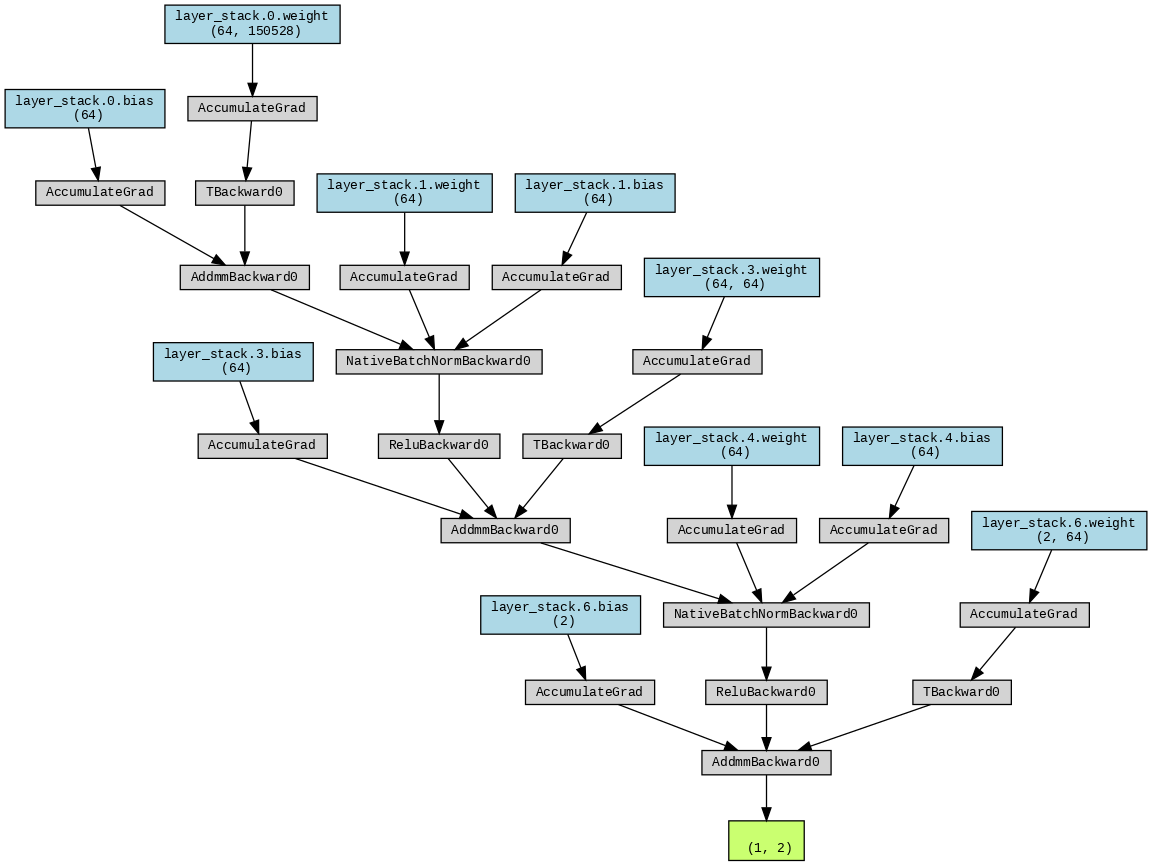